# Writeup - Vehicle Detection Project

Welcome to my writeup on vehicle detection project. This notebook contains both discussion and source code for each step.

The steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


## Rubric Points
Here I will consider the [rubric points](https://review.udacity.com/#!/rubrics/513/view) individually and describe how I addressed each point in my implementation.  

---
### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the cell below. I used the function `skimage.feature.hog` from the [scikit-image](http://scikit-image.org) library. In the function `get_hog_feaures` I can choose the number of pixels per cell, cells per block, orientation bins and the format of the feature vector.

In [19]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

I started by reading in all the `vehicle` and `non-vehicle` images.

In [2]:
import glob
import cv2

def data_files(vehicle):
    if vehicle:
        pattern = 'data/vehicles/*/*.png'
    else:
        pattern = 'data/non-vehicles/*/*.png'
        
    files = glob.glob(pattern)
    return files

def images(vehicle):
    img_files = data_files(vehicle)
    imgs = [cv2.imread(f) for f in img_files]
    return imgs

vehicles = data_files(vehicle=True)
non_vehicles = data_files(vehicle=False)

Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

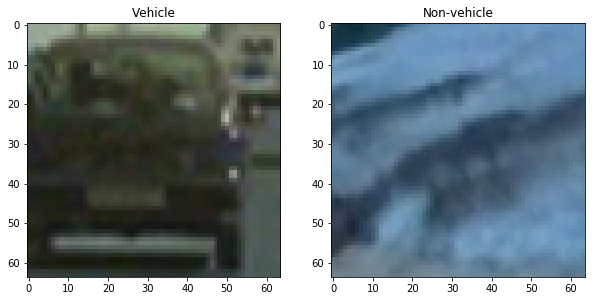

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("Vehicle")
choice = np.random.choice(range(len(vehicles)))
plt.imshow(cv2.imread(vehicles[choice]))
plt.subplot(122)
plt.title("Non-vehicle")
choice = np.random.choice(range(len(vehicles)))
plt.imshow(cv2.imread(non_vehicles[choice]))

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:

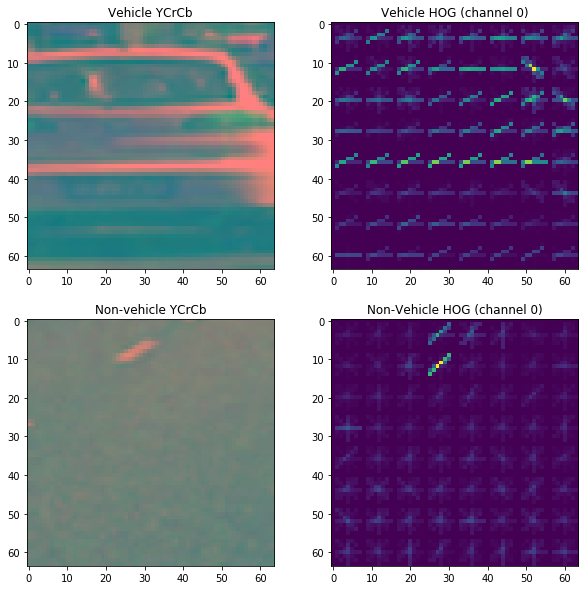

In [8]:
fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title("Vehicle YCrCb")
choice = np.random.choice(range(len(vehicles)))
choice_img = cv2.imread(vehicles[choice])
converted = cv2.cvtColor(choice_img, cv2.COLOR_BGR2YCrCb) 
plt.imshow(converted)

plt.subplot(222)
plt.title("Vehicle HOG (channel 0)")
# HOG features
_, hog_image = get_hog_features(converted[:,:,0], 
                    orient=8, pix_per_cell=8, cell_per_block=2, 
                    vis=True, feature_vec=False)
plt.imshow(hog_image)

plt.subplot(223)
plt.title("Non-vehicle YCrCb")
choice = np.random.choice(range(len(non_vehicles)))
choice_img = cv2.imread(non_vehicles[choice])
converted = cv2.cvtColor(choice_img, cv2.COLOR_BGR2YCrCb) 
plt.imshow(converted)

plt.subplot(224)
plt.title("Non-Vehicle HOG (channel 0)")
# HOG features
_, hog_image  = get_hog_features(converted[:,:,0], 
                    orient=8, pix_per_cell=8, cell_per_block=2, 
                    vis=True, feature_vec=False)
plt.imshow(hog_image)

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and conclude that using the `YCrCb` color space and HOG parameters of `orientations=9`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)` is a good set of parameters (refer to section 3 for classification results).

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

First, we define the functions to extract HOG and color/spatial features to be used to train the classifier:

In [98]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract color features from a list of images
def extract_features_color(feature_image, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    
    # Return list of feature vectors
    return np.concatenate((spatial_features, hist_features))

# Define a function to extract HOG features from a list of images
def extract_features_hog(feature_image, orient=9, 
                     pix_per_cell=8, cell_per_block=2, 
                     hog_channel=0, feature_vec=True):
    
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=feature_vec))
        if feature_vec:
            hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=feature_vec)
        
    # Return list of feature vectors
    return hog_features

def extract_features(imgs, cspace='BGR', orient=9, 
                     pix_per_cell=8, cell_per_block=2, 
                     hog_channel=0, feature_vec=True,
                     spatial_size=(32, 32), hist_bins=32,
                     hist_range=(0, 256)):
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        image = image.astype(np.float32)/255
        
        # apply color conversion if other than 'BGR'
        if cspace != 'BGR':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)
        
        spatial_hist_features = extract_features_color(feature_image, spatial_size, 
                                                       hist_bins, hist_range)
        hog_features = extract_features_hog(feature_image, orient, 
                                            pix_per_cell, cell_per_block, 
                                            hog_channel, feature_vec)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_hist_features, hog_features)))
        
    return features

Now we need to extract all features from vehicles and non-vehicles images, using the function `extract_features`:

In [188]:
import time

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32)
hist_bins = 32

t=time.time()
vehicle_features = extract_features(vehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size, hist_bins=hist_bins)

non_vehicle_features = extract_features(non_vehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size, hist_bins=hist_bins)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

print(X.shape, y.shape)

77.23 Seconds to extract HOG features...
(17760, 8460) (17760,)


The next step is to standardize the data (remove the mean and scaling to unit variance) using [`StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from scikit-learn library:

In [189]:
from sklearn.preprocessing import StandardScaler

# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

Split the data in training and test data. This is useful to check if the model is over/underfitting:

In [202]:
from sklearn.model_selection import train_test_split

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15984, 8460) (15984,)
(1776, 8460) (1776,)


Finally, we are ready to train the classifier. We choose the [`LinearSVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) classifier as suggested in the project rubric:

In [203]:
from sklearn.svm import LinearSVC
from sklearn import metrics
import time

print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

print("Classification report:\n%s\n" % metrics.classification_report(y_test, svc.predict(X_test)))

Feature vector length: 8460
24.98 Seconds to train SVC...
Test Accuracy of SVC =  0.9899
My SVC predicts:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
0.00111 Seconds to predict 10 labels with SVC
Classification report:
             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       897
        1.0       0.99      0.99      0.99       879

avg / total       0.99      0.99      0.99      1776




### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I used the HOG sub-sampling strategy suggested in the lesson `Hog Sub-sampling Window Search`. This method (see function `find_cars` in the cell below) uses 2 cells step (75% overlap) and results in better performance because the HOG features are extracted only once per frame. I chose not to use multi-scale windows because we can derive larger windows from smaller windows using heatmaps (see section 3).

In [95]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins):
    
    #print(np.min(img), np.max(img))
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, 
                                                          hist_features, 
                                                          hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(hog_features.reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                bboxes.append(((xbox_left, ytop_draw+ystart), 
                               (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                                
    return bboxes

def draw_boxes(img, boxes):
    
    for box in boxes:
        cv2.rectangle(img, box[0], box[1], (0,0,255),6) 
    return img

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:

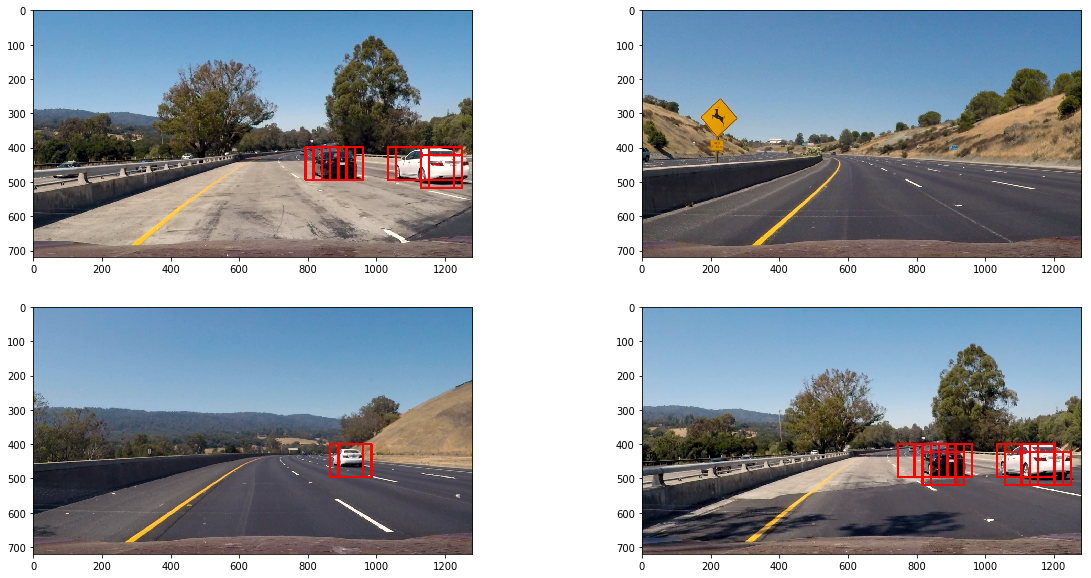

In [206]:
ystart = 400
ystop = 656
scale = 1.5

fig = plt.figure(figsize=(20,10))
files = glob.glob('test_images/*.jpg')[:4]

for i, f in enumerate(files):
    
    plt.subplot(len(files)/2,2, i+1)
    img = cv2.imread(f)
    boxes = find_cars(img, ystart, ystop, scale, 
                      svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block, 
                      spatial_size, hist_bins)
    
    out_img = draw_boxes(img, boxes)
    plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))

#### 3. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video. From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions. I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap. I then assumed each blob corresponded to a vehicle. I constructed bounding boxes to cover the area of each blob detected.

In [111]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    # Return the image
    return img

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

#### Here are six frames and their corresponding heatmaps:

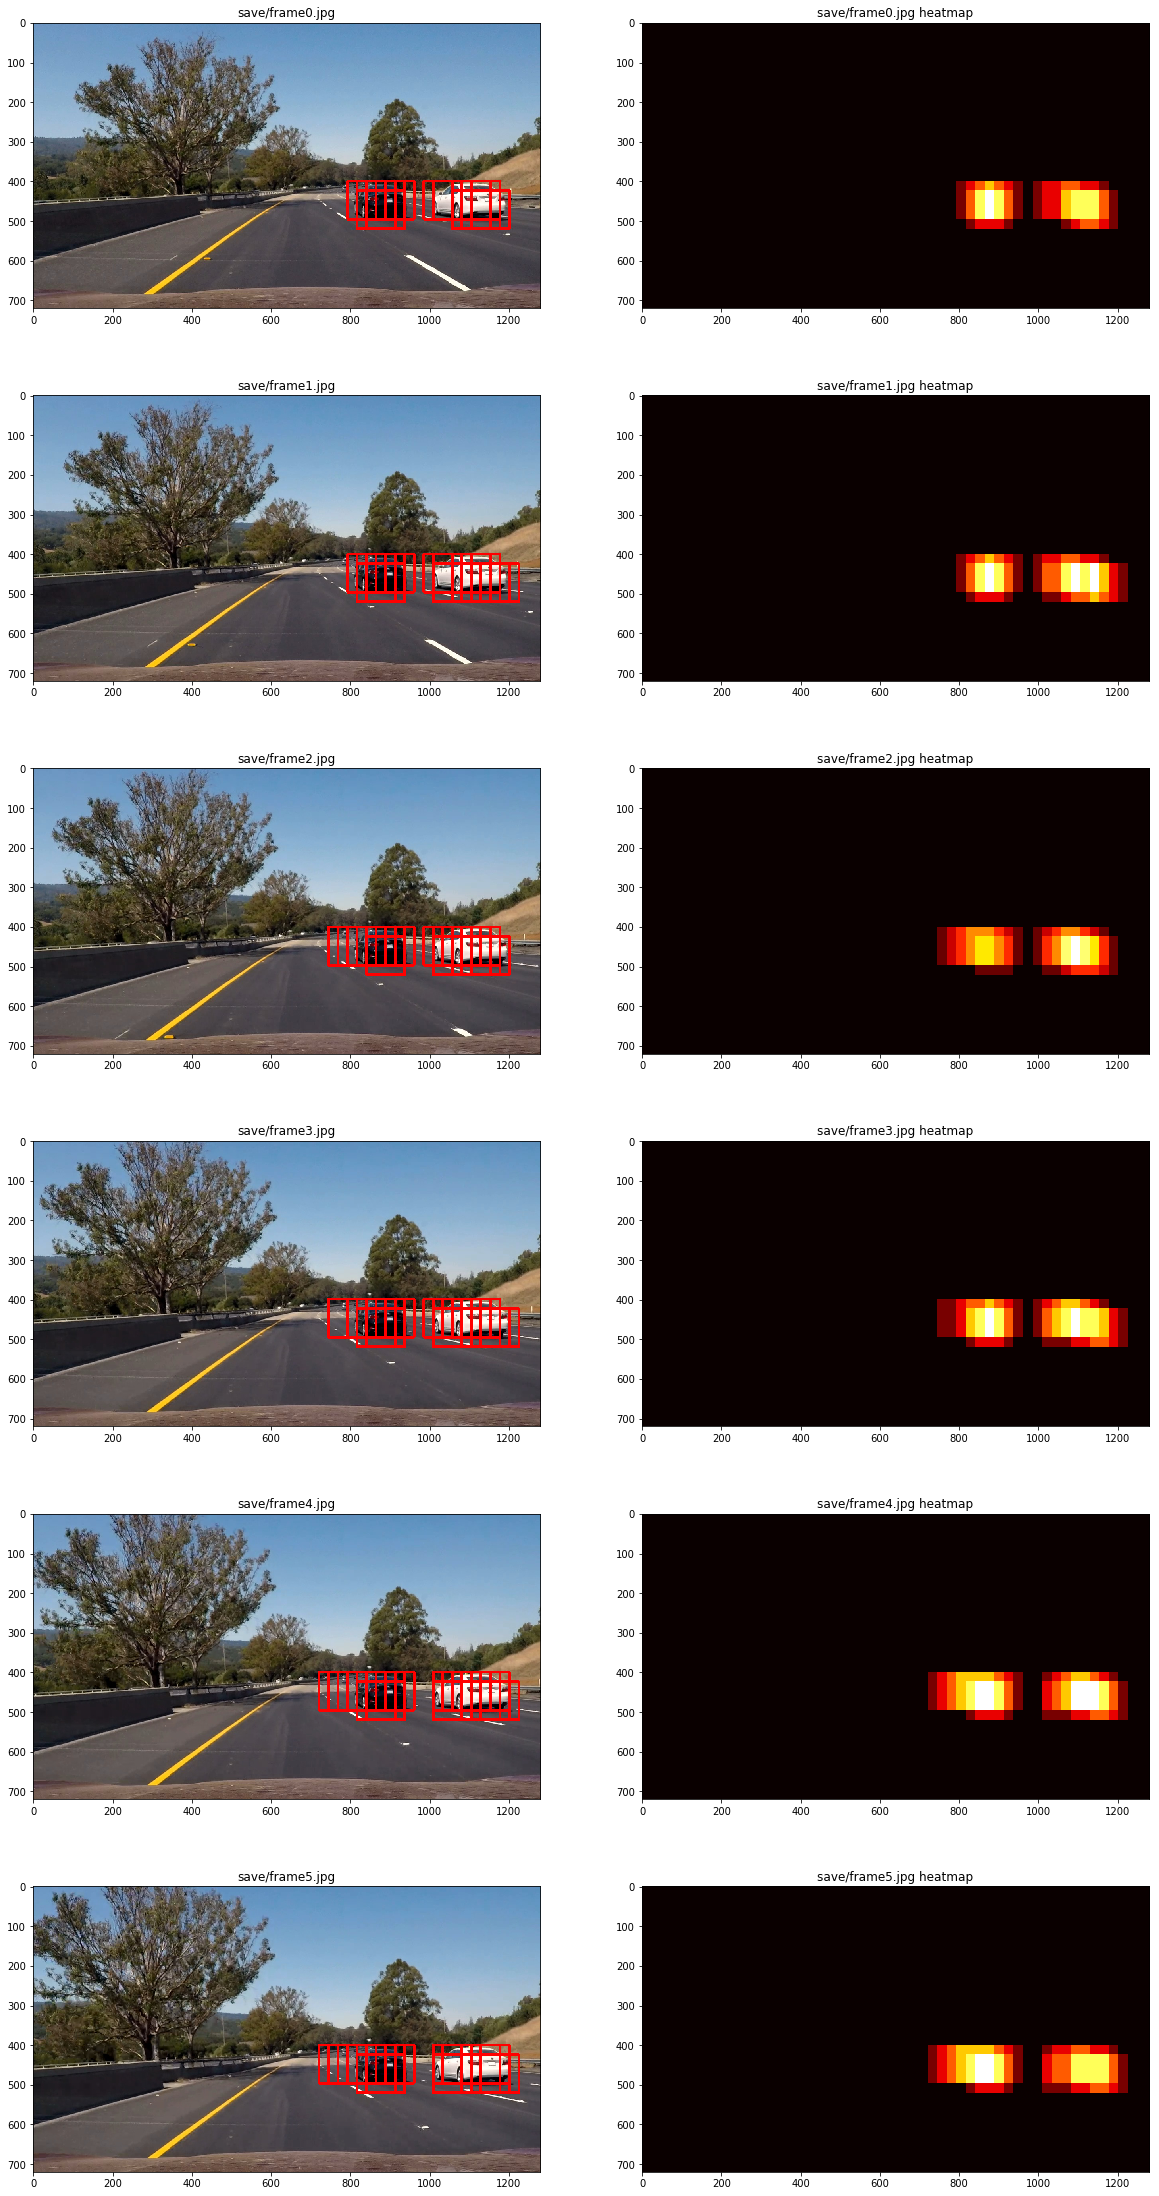

In [207]:
fig = plt.figure(figsize=(20,40))
files = glob.glob('test_images/frame*.jpg')[:6]

for i, f in enumerate(files):
    
    img = cv2.imread(f)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    boxes = find_cars(img, ystart, ystop, scale, 
                      svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block, 
                      spatial_size, hist_bins)
    frame = draw_boxes(img, boxes)
    
    plt.subplot(len(files), 2, 2*i+1)
    plt.title(f)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    # Add heat to each box in box list
    heat = add_heat(heat, boxes)
    
    # Visualize the heatmap when displaying    
    heat = np.clip(heat, 0, 255)

    plt.subplot(len(files), 2, 2*i+2)
    plt.title(f + ' heatmap')
    plt.imshow(heat, cmap='hot')

#### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:

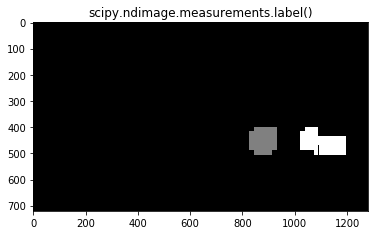

In [254]:
from scipy.ndimage.measurements import label
from collections import deque

heats = deque()

def get_labels(img, history_size=10, threshold=10, scale=1.):
    '''
    Get labels using `history_size` frames after
    applying a specified heatmap `threshold`.
    '''
    
    # remove oldest heatmap from list
    if len(heats) == history_size:
        old_heat = heats.popleft()
        for i, h in enumerate(heats):
            heats[i] = heats[i] - old_heat
    
    if len(heats) == 0:
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
    else:
        heat = heats[-1]
    
    boxes = find_cars(img, ystart, ystop, scale, 
                      svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block, 
                      spatial_size, hist_bins)
    
    # Add heat to each box in box list
    heat = add_heat(heat, boxes)
    
    heats.append(heat)
    
    # Visualize the heatmap when displaying    
    heat = np.clip(heat.copy(), 0, 255)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    
    # Find final boxes from heatmap using label function
    return label(heat)

files = glob.glob('test_images/frame*.jpg')[:10]

for i, f in enumerate(files):
    
    img = cv2.imread(f)
    labels = get_labels(img, scale=1.1)
   
plt.title('scipy.ndimage.measurements.label()')
plt.imshow(labels[0], cmap='gray')

#### Here the resulting bounding boxes are drawn onto the last frame in the series:

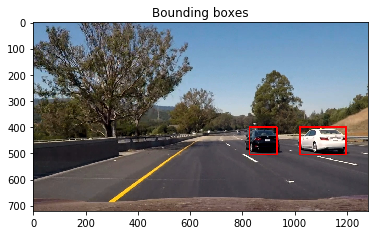

In [249]:
file = glob.glob('test_images/frame*.jpg')[5]
img = cv2.imread(file)
img = draw_labeled_bboxes(img, labels)
plt.title("Bounding boxes")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./vehicle_detection.mp4)

In [250]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

heats = deque()

def process_image(frame):
    labels = get_labels(frame, threshold=3, scale=1.)
    return draw_labeled_bboxes(frame, labels)

clip = VideoFileClip('project_video.mp4')
white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile('vehicle_detection.mp4', audio=False)

[MoviePy] >>>> Building video vehicle_detection.mp4
[MoviePy] Writing video vehicle_detection.mp4


100%|█████████▉| 1260/1261 [18:10<00:00,  1.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle_detection.mp4 

CPU times: user 1h 6min 13s, sys: 2min 49s, total: 1h 9min 2s
Wall time: 18min 11s


#### 2. Combining vehicle and lane detection!
Here's a [link to my video result](./vehicle_line_detection.mp4)

In [256]:
%load_ext autoreload
%autoreload
import lane_detection as lanes
import pickle

# load calibration and distortion coefficients
with (open("camera_cal/calibration.p", "rb")) as openfile:
    dist_pickle = pickle.load(openfile)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

# some globals to keep data from last frames 
left_fit = None
right_fit = None
left_fits = []
right_fits = []

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes)
    
    global left_fit
    global right_fit
    global left_fits
    global right_fits
    
    frame, left_fit, right_fit = lanes.find_lane(image, mtx, dist, 
                                           left_fit=left_fit, 
                                           right_fit=right_fit)
    # smooth coefficients
    left_fit, right_fit = lanes.smooth_fit(left_fit, right_fit, 
                                     left_fits, right_fits)
    frame = frame*255
    
    labels = get_labels(frame, threshold=3, scale=1.)
    font = cv2.FONT_HERSHEY_PLAIN
    cv2.putText(frame, 'Cars detected: {}'.format(labels[1]), (50,200), font, 4, (255,255,255), 3)
    return draw_labeled_bboxes(frame, labels)

clip = VideoFileClip('project_video.mp4')
white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile('vehicle_line_detection.mp4', audio=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[MoviePy] >>>> Building video vehicle_line_detection.mp4
[MoviePy] Writing video vehicle_line_detection.mp4


100%|█████████▉| 1260/1261 [24:55<00:01,  1.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle_line_detection.mp4 

CPU times: user 1h 31min 52s, sys: 5min 45s, total: 1h 37min 37s
Wall time: 24min 56s


---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

* **The good**:

I am really surprised about how efficient the SVM classifier can be. It can achieve an accuracy higher than 99% in less then 10 seconds of training (using features vectors with more than 10k dimensions)!

* **The bad**:

While the SVM classifier is very efficient, we have to rely on handcrafted features. This suggests that the algorithm will probably fail in different weather and lighting conditions. Moreover, in real life we will have to detect pedestrian, traffic signs and other elements. This means a huge amount parameter tuning for each class. Maybe a Deep Learning model would be more suited to a multiclass situation (albeit harder to train).

The detection boxes are very unstable. While the heatmap strategy is good for removing false positives, we could also implement some temporal sanity checking between frames (a car should not "disappear" in the next frame).

Another major problem is the performance of the algorithm. The pipeline can process only 1 frame per second, which is not viable for real world application. This issue may be solved if we use GPU acceleration, since [opencv supports CUDA](http://opencv.org/platforms/cuda.html) with performance gains up to 30x for primitive image operations.

---

That's it! Thanks for reading! &#128663;